## Outline
- [Introduction](#0)
    - [Import libraries](#0.1)
- [Part 1:  Explore the data](#1)
    - [1.1  Import the datasets](#1.1)
    - [1.2  Exploratory Analysis](#1.2)
    - [Conclusion after analysis](#1.3)
    
- [Part 2:  Pre-process the data](#2)
    - [2.1  Stemming](#2.1)
    - [2.2  Lemmatization](#2.2)
    - [2.3  Replacement](#2.3)
    - [2.4  Pre-processing pipeline](#2.4)
    - [2.5  Split to train/val datasets](#2.5)
    - [2.6  Tokenization and Padding](#2.6)
    - [2.7  Check the Imbalance in train dataset](#2.7)
    - [2.8  One-hot encoding](#2.8)

- [Part 3:  Build the model](#3)
    - [3.1  Glove Embedding](#3.1)
    - [3.2  Define the model](#3.2)
    - [3.3  Callbacks](#3.3)
    

- [Part 4:  Train the model](#4)
- [Part 5:  Test the model](#5)
- [Part 6:  Test with your own sentence](#6)

- [Part 7:  Analyse the incorrect predictions](#7)
    - [Potential improvement](#7.1)

- [Export result to .tsv file](#8)



<a name="0"></a>
# Introduction


<a name="0.1"></a>
## Import libraries

In [ ]:
!python --version
import os

%tensorflow_version 2.x
import tensorflow as tf
print(tf.__version__)

# build the tokenized sentences and tags
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.initializers import Constant
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, \
TimeDistributed, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from collections import Counter
import random as rnd
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer 
from nltk.stem import PorterStemmer

!pip install sklearn_crfsuite
from sklearn_crfsuite.metrics import flat_classification_report
!pip install seqeval
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report
import csv


Python 3.7.10
2.5.0
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
     |████████████████████████████████| 747kB 12.5MB/s 
     |████████████████████████████████| 51kB 5.0MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-cp37-none-any.whl size=16184 sha256=ae07dcf27893686fb86ad23dc99961e6c43db9b655a080d92441256538067ba7
  Stored in directory: /root/.cache/pip/wheels/52/df/1b/45d75646c37428f7e626214704a0e35bd3cfc32eda37e59e5f
Successfully built seqeval


<a name="1"></a>
# Part 1:  Explore the data

<a name="1.1"></a>
## 1.1 Import the datasets

In [ ]:
# Create new directories
!mkdir -p /data/eng
!mkdir -p /data/trivia10k13
!mkdir -p /model

# Download data
!wget --no-check-certificate \
https://groups.csail.mit.edu/sls/downloads/movie/engtrain.bio \
-O /data/eng/train.tsv

!wget --no-check-certificate \
https://groups.csail.mit.edu/sls/downloads/movie/engtest.bio \
-O /data/eng/test.tsv

!wget --no-check-certificate \
https://groups.csail.mit.edu/sls/downloads/movie/trivia10k13train.bio \
-O /data/trivia10k13/train.tsv

!wget --no-check-certificate \
https://groups.csail.mit.edu/sls/downloads/movie/trivia10k13test.bio \
-O /data/trivia10k13/test.tsv

--2021-06-03 08:19:10--  https://groups.csail.mit.edu/sls/downloads/movie/engtrain.bio
Resolving groups.csail.mit.edu (groups.csail.mit.edu)... 128.30.2.44
Connecting to groups.csail.mit.edu (groups.csail.mit.edu)|128.30.2.44|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1013492 (990K)
Saving to: ‘/data/eng/train.tsv’

/data/eng/train.tsv 100%[===================>] 989.74K  1.85MB/s    in 0.5s    

2021-06-03 08:19:11 (1.85 MB/s) - ‘/data/eng/train.tsv’ saved [1013492/1013492]

--2021-06-03 08:19:11--  https://groups.csail.mit.edu/sls/downloads/movie/engtest.bio
Resolving groups.csail.mit.edu (groups.csail.mit.edu)... 128.30.2.44
Connecting to groups.csail.mit.edu (groups.csail.mit.edu)|128.30.2.44|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252636 (247K)
Saving to: ‘/data/eng/test.tsv’

/data/eng/test.tsv  100%[===================>] 246.71K   714KB/s    in 0.3s    

2021-06-03 08:19:12 (714 KB/s) - ‘/data/eng/test.tsv’ saved [2

In [ ]:
def get_sentence(file_path):
    '''
        Input:
            file_path - path to the tsv file
        Output:
            sentences - list of sentences in string format
            tags - list associated tags in string format
    '''
    sentences = []
    tags = []
    with open(file_path) as f:
        contents = f.read()
        sens_tags = contents.split("\n\n")
        for sen_tag in sens_tags:
            words_tags = sen_tag.split("\n")
            while ("" in words_tags):
                words_tags.remove("")
            sen = ' '.join([word_tag.split("\t")[1] for word_tag in words_tags])
            tag = ' '.join([word_tag.split("\t")[0] for word_tag in words_tags])
            sentences.append(sen)
            tags.append(tag)

    return sentences, tags


train_path = "/data/eng/train.tsv"
test_path = "/data/eng/test.tsv"

sentences, tags = get_sentence(train_path)
test_sentences, test_tags = get_sentence(test_path)

print("The train dataset has {} sentences.".format(len(sentences)))
print("The test dataset has {} sentences.".format(len(test_sentences)))

The train dataset has 9776 sentences.
The test dataset has 2444 sentences.


<a name="1.2"></a>
## 1.2 Exploratory Analysis

In [ ]:
# Take a look at the data
df = pd.read_csv(train_path, delimiter="\t", names=["Tag", "Word"])
df.head()

,Tag,Word
0,O,what
1,O,movies
2,O,star
3,B-ACTOR,bruce
4,I-ACTOR,willis


<a name="1.2.1"></a>
### 1.2.1 Sentence Length 


Min:  1
Max:  47
Median:  9.0
Average:  10.18


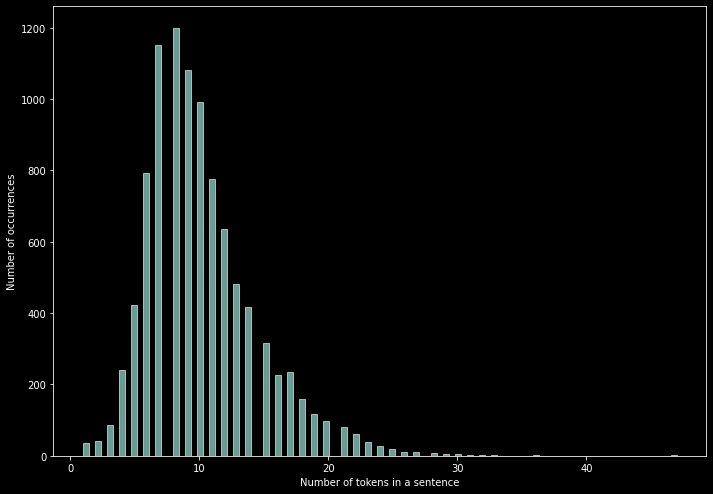

In [ ]:
plt.style.use("dark_background")

# How long are the sentences?
def plot_sentence_length_histogram(list_sentences):
    '''
      Input:
        list_sentences - a list of sentences
      Output:
        [print] - Min, Max, Median and Average value of sentence length
        [plot] - Histogram plot of sentence length
    '''
    lengths = [len(sen.split(' ')) for sen in list_sentences]
    a4_dims = (11.7, 8.27)
    fig, ax = plt.subplots(figsize=a4_dims)
    sns.histplot(lengths)
    plt.xlabel("Number of tokens in a sentence")
    plt.ylabel("Number of occurrences")
    print("Min: ",np.min(lengths))
    print("Max: ",np.max(lengths))
    
    print("Median: ",np.median(lengths))
    print("Average: ",round(np.mean(lengths),2))

plot_sentence_length_histogram(sentences)

### 1.2.2 Entity Length

Min:  1
Max:  16
Median:  2.0
Average:  1.81


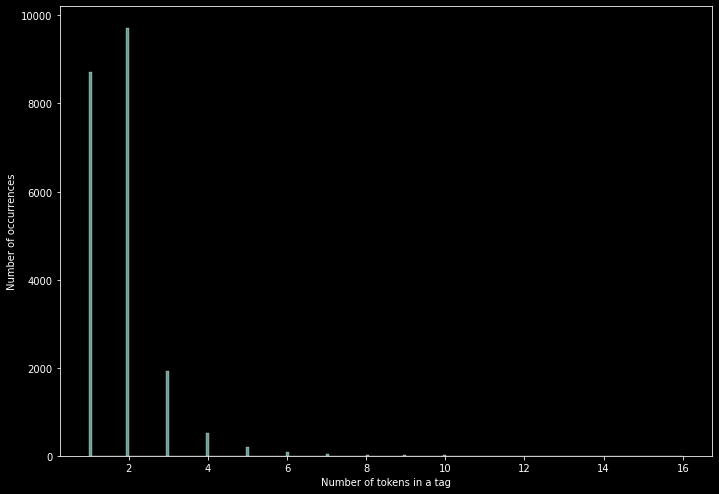

In [ ]:
# How long are the entities?
def plot_entity_length_histogram(series):
    '''
      Input:
        series - a pandas series of the tags
      Output:
        [print] - Min, Max, Median and Average value of entity length
        [plot] - Histogram plot of entity length
    '''
    tags_list=[tag for tag in series]
    tag_length = []
    current_length = 0
    for tag in tags_list:
        if tag.startswith("B"):
            tag_length.append(current_length)
            current_length = 1
        elif tag.startswith("I"):
            current_length += 1
    tag_length = tag_length[1:]
    
    a4_dims = (11.7, 8.27)
    fig, ax = plt.subplots(figsize=a4_dims)
    sns.histplot(tag_length)
    plt.xlabel("Number of tokens in a tag")
    plt.ylabel("Number of occurrences")
    print("Min: ",np.min(tag_length))
    print("Max: ",np.max(tag_length))
    print("Median: ",np.median(tag_length))
    print("Average: ",round(np.mean(tag_length),2))

plot_entity_length_histogram(df["Tag"])

### 1.2.3 Token frequency

There are 6710 distinct words in dataset
{'what': 2938, 'movies': 1702, 'star': 303, 'bruce': 37, 'willis': 24, 'show': 588, 'me': 958, 'films': 510, 'with': 1302, 'drew': 12, 'barrymore': 8, 'from': 895, 'the': 5331, '1980s': 74, 'starred': 245, 'both': 8, 'al': 23, 'pacino': 17, 'and': 777, 'robert': 86, 'deniro': 11, 'find': 810, 'all': 278, 'of': 1414, 'that': 1640, 'harold': 3, 'ramis': 2, 'bill': 33, 'murray': 14, 'a': 4224, 'movie': 3533, 'quote': 53, 'about': 1182, 'baseball': 11, 'in': 2789, 'it': 197, 'have': 335, 'mississippi': 3, 'title': 133, 'science': 163, 'fiction': 162, 'directed': 1122, 'by': 940, 'steven': 50, 'spielberg': 34, 'do': 231, 'you': 413, 'any': 738, 'thrillers': 21, 'sofia': 10, 'coppola': 26, 'leonard': 8, 'cohen': 4, 'songs': 18, 'been': 178, 'used': 16, 'elvis': 10, 'set': 39, 'hawaii': 2, 'is': 2214, 'references': 1, 'zydrate': 1, 'are': 765, 'there': 1062, 'musical': 107, 'patrick': 23, 'dempsey': 1, 'list': 795, 'westerns': 21, 'starring': 759, 'joh

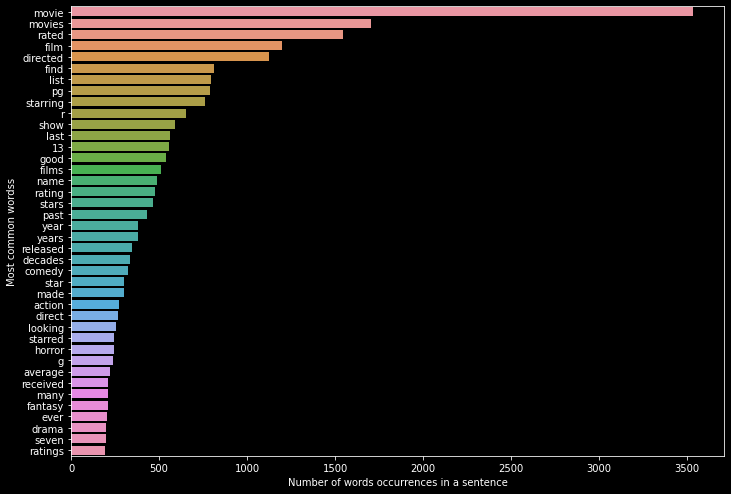

In [ ]:
def plot_top_non_stopwords_barchart(series, top=20, word=True):
    '''
      Input:
        series - a pd.Series of words or tags
        top - number of most common words to plot
      Output:
        [print] - No of distinct words in train dataset
        [plot] - Barchart of most common words' occurrence
    '''
    stop=set(stopwords.words('english'))
    value = 'words' if word == True else 'tags'
    corpus=[word for word in series]
    counter=Counter(corpus)
    print("There are {} distinct {} in dataset".format(len(dict(counter)), value))
    print(dict(counter))

    most=counter.most_common()
    x, y=[], []
    for word,count in most:
        if (word not in stop):
            x.append(count)
            y.append(word)
        if len(x) == top:
          break
    a4_dims = (11.7, 8.27)
    fig, ax = plt.subplots(figsize=a4_dims)
    sns.barplot(x=x,y=y)
    plt.xlabel("Number of {} occurrences in a sentence".format(value))
    plt.ylabel("Most common {}s".format(value))
    return dict(counter)

word_counter = plot_top_non_stopwords_barchart(df["Word"], top=40)

### 1.2.4 Cumulative token frequency

Vocabulary Size:  6710


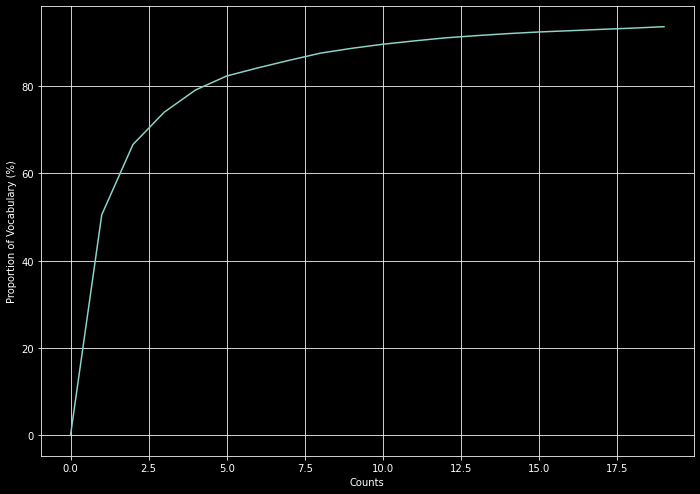

In [ ]:
# Plot the cumulative distribution of token frequency
def cumulative_token_frequency(series, limit=20):
    '''
      Input:
        series - pd.Series of words
      Output:
        [plot] - cumulative distribution of token frequency
    '''
    corpus=[word for word in series]
    counter=Counter(corpus)
    tokens_count = dict(counter).items()

    prop_list = []
    print("Vocabulary Size: ", len(tokens_count))
    for i in range(limit):
        tokens_filtered = len(list(filter(lambda x: x[1]<=i, tokens_count)))
        prop_list.append(round(tokens_filtered*100/len(tokens_count),2))
    a4_dims = (11.7, 8.27)
    fig, ax = plt.subplots(figsize=a4_dims)
    plt.plot(prop_list)
    plt.grid()
    plt.xlabel("Counts")
    plt.ylabel("Proportion of Vocabulary (%)")
    # print("Proportion of unique words less than",limit,": ", round(tokens_filtered*100/len(tokens_dict),2),"%")

cumulative_token_frequency(df["Word"])

### 1.2.5 Entity Frequency

There are 25 distinct tags in dataset
{'O': 61008, 'B-ACTOR': 3220, 'I-ACTOR': 3474, 'B-YEAR': 2858, 'B-TITLE': 2376, 'B-GENRE': 4354, 'I-GENRE': 786, 'B-DIRECTOR': 1720, 'I-DIRECTOR': 1850, 'B-SONG': 245, 'I-SONG': 446, 'B-PLOT': 1927, 'I-PLOT': 1687, 'B-REVIEW': 221, 'B-CHARACTER': 385, 'I-CHARACTER': 342, 'B-RATING': 2007, 'B-RATINGS_AVERAGE': 1869, 'I-RATINGS_AVERAGE': 1673, 'I-TITLE': 3495, 'I-RATING': 840, 'B-TRAILER': 113, 'I-TRAILER': 7, 'I-REVIEW': 132, 'I-YEAR': 2456}


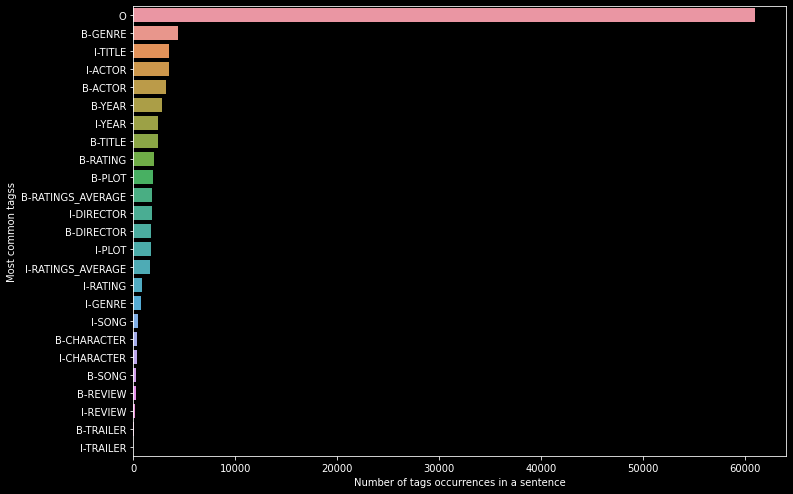

In [ ]:
tag_counter = plot_top_non_stopwords_barchart(df["Tag"], top=25, word=False)

<a name="1.3"></a>
## Conclusion after analysis

### Vocab
1. The vocab size is 6710. This is not a large dataset.
2. Our dataset it comprised of short sentences, with average length of 10 and median length of 9, and the length ranges from 1 to 47. Only a small amount of sentences have the length greater than 30 => set the max length equal to 30 => need a lot of padding tokens.
3. 50% of the vocabulary only occur once but they could be person's names so let's keep them.
4. Year: can be replaced by a common
5. Number in text: can be replaced by a common
6. Lemmatization: *films* to *film*
7. All words are in lowercase.
8. No punctuations.
9. No informal text.
10. No abbreviation (like *'ll, can't, 2morrow*)


### Tags
1. Most of tags are short, with median length and average length of 2 words. The longest tag has 16 words. This could be a movie name.
2. Most sentences are about movies and ratings.
3. There are 25 classes of entities, divided to 3 categories: B Tags (Beginning of an entity), I Tag (Intermediate Entity), Or None Tag (O). Proportions of B,I,O are about 21.40%, 17.28%, 61.32% respectively.
4. Most of the tags are in the minority and O is the most common entity => need to over-sample the tags from the minority groups.
5. As under the section 2.7 Check the dataset imbalance, the percentage of sentences that only contain O tags -> 0.59% => It's small amount so we don't need to delete those sentences.
6. ALso under the section 2.7 Check the dataset imbalance, the percentage of OOV tokens in test set -> 3.53%




<a name="2"></a>
# Part 2:  Pre-process the data



<a name="2.1"></a>
## 2.1 Stemming

In [ ]:
def stem_sentence(sentence):
    sentence = sentence.split(' ')
    stemmer = PorterStemmer()
    result = [stemmer.stem(word) for word in sentence]
    stemmed_sentence = ' '.join(result)
    return stemmed_sentence

<a name="2.2"></a>
## 2.2 Lemmatization

In [ ]:
nltk.download('punkt')
nltk.download('wordnet')
def lemmatize_sentence(sentence):
    tokenization = nltk.word_tokenize(sentence)
    lemmatizer = WordNetLemmatizer()
    result = [lemmatizer.lemmatize(word) for word in tokenization]
    lemmatized_sentence = ' '.join(result)
    return lemmatized_sentence

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


<a name="2.3"></a>
## 2.3 Replacement

In [ ]:
import re

def replace(sentence, to_replace, replace_by):
    replaced = sentence.replace(to_replace, replace_by)
    return replaced

def replace_num(sentence):
    replaced = re.sub(r'^\d{1,2}$', "NUM", sentence) # replace 1, 2 digits
    replaced = re.sub(r'^\d{4}$', "YEAR", replaced) # replace year
    replaced = re.sub(r'^\d{4}s$', "YEAR", replaced) # replace year
    return replaced


<a name="2.4"></a>
## 2.4 Pre-processing pipeline

In [ ]:
def apply_preproc(data_generator):
    data_generator = list(map(lambda x: replace(x, "ca n t","cannot"), data_generator))
    data_generator = list(map(lambda x: replace(x, "ll","will"), data_generator))
    data_generator = list(map(lambda x: replace_num(x), data_generator))
    data_generator = list(map(lambda x: lemmatize_sentence(x), data_generator))
    return data_generator

processed_sentences = apply_preproc(sentences)
processed_test_sentences = apply_preproc(test_sentences)

<a name="2.5"></a>
## 2.5 Split to train/val datasets

In [ ]:
split_ratio = 0.8

def train_val_split(data, label, ratio, shuffle=True, random_seed=33):
    length = len(data)
    lines_index = [*range(length)]  
    # shuffle the indexes if shuffle is set to True
    rnd.seed(random_seed)
    if shuffle:
        rnd.shuffle(lines_index)
    split_point = int(length * ratio)

    train_data = []
    train_label = []
    val_data = []
    val_label = []
    for i in range(length):
        if i <= split_point:
            train_data.append(data[lines_index[i]])
            train_label.append(label[lines_index[i]])
        else:
            val_data.append(data[lines_index[i]])
            val_label.append(label[lines_index[i]])
    return train_data, train_label, val_data, val_label


train_sentences, train_tags, val_sentences, val_tags = \
      train_val_split(processed_sentences, tags, split_ratio)

<a name="2.6"></a>
## 2.6 Tokenization and Padding

In [ ]:
oov_tok = "<OOV>"
trunc_type='post'
pad_type='post'
max_length = 50

vocab_tokenizer = Tokenizer(oov_token=oov_tok)
vocab_tokenizer.fit_on_texts(train_sentences)

vocab = vocab_tokenizer.word_index
reverse_vocab = dict([(value, key) for (key, value) in vocab.items()])
vocab_size = len(vocab)


train_sequences = vocab_tokenizer.texts_to_sequences(train_sentences)
val_sequences = vocab_tokenizer.texts_to_sequences(val_sentences)
test_sequences = vocab_tokenizer.texts_to_sequences(processed_test_sentences)

train_padded_sequences = pad_sequences(train_sequences,
                                        maxlen=max_length, 
                                        truncating=trunc_type, 
                                        padding=pad_type)

val_padded_sequences = pad_sequences(val_sequences,
                                      maxlen=max_length, 
                                      truncating=trunc_type, 
                                      padding=pad_type)

test_padded_sequences = pad_sequences(test_sequences,
                                      maxlen=max_length, 
                                      truncating=trunc_type, 
                                      padding=pad_type)

In [ ]:
tag_tokenizer = Tokenizer(filters=".", lower=False, oov_token=oov_tok)
tag_tokenizer.fit_on_texts(train_tags)

tag_map = tag_tokenizer.word_index
reverse_tag_map = dict([(value, key) for (key, value) in tag_map.items()])
tag_size = len(tag_map)

train_tag_sequences = tag_tokenizer.texts_to_sequences(train_tags)
val_tag_sequences = tag_tokenizer.texts_to_sequences(val_tags)
test_tag_sequences = tag_tokenizer.texts_to_sequences(test_tags)


train_padded_tags = pad_sequences(train_tag_sequences,
                                        maxlen=max_length, 
                                        truncating=trunc_type, 
                                        padding=pad_type)

val_padded_tags = pad_sequences(val_tag_sequences,
                                      maxlen=max_length, 
                                      truncating=trunc_type, 
                                      padding=pad_type)

test_padded_tags = pad_sequences(test_tag_sequences,
                                      maxlen=max_length, 
                                      truncating=trunc_type, 
                                      padding=pad_type)

print("\nExample of a a sentence and its tokenized, padded version")
print(train_sentences[0])
print(train_padded_sequences[0])
print("\nExample of a list of tags in a sentence and its tokenized, padded version")
print(train_tags[0])
print(train_padded_tags[0])



Example of a a sentence and its tokenized, padded version
what is the movie triangle
[   5    7    2    3 1866    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]

Example of a list of tags in a sentence and its tokenized, padded version
O O O O B-TITLE
[2 2 2 2 9 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]


<a name="2.7"></a>
## 2.7 Check the Imbalance in train/test dataset

In [ ]:
#Percentage of B, I and O Tags in train dataset
def get_tag_proportion(series_tags):
    '''
      Input:
        series_tags - pd.Series of tags
      Output:
        [print] - B, I and O tags' proportion
    '''
    tags_list=[tag for tag in series_tags]
    counter=dict(Counter(tags_list))
    beg = 0
    inter = 0
    out = 0
    for key, value in counter.items():
        if key.startswith("B"):
            beg += value
        elif key.startswith("I"):
            inter += value
        else:
            out += value
    total = len(tags_list)
    print("B tags proportion = {0:.2%}".format(round(beg/total,4)))
    print("I tags proportion = {0:.2%}".format(round(inter/total,4)))
    print("O tags proportion = {0:.2%}".format(round(out/total,4)))

get_tag_proportion(df["Tag"])

# Percentage of sentences that only contain O tags
# If this percentage > 50% => the dataset is imbalanced => drop empty sentences
def get_empty_tag_sentence_proportion(list_tag_sequence):
    '''
      Input:
        list_tag_sequence - list of tag sequences in train/test set
      Output:
        [print] - Percentage of sentences that only contain O tags
    '''
    count = 0
    for seq in list_tag_sequence:
        if sum(seq) == 2 * len(seq): # if seq contains only 2 (token for O tag)
            count += 1

    
    print("\nPercentage of sentences that only contain O tags -> {0:.2%}".\
          format(round(count/len(list_tag_sequence),4)))
    
get_empty_tag_sentence_proportion(train_tag_sequences)

def get_OOV_density(list_token_sequence):
    '''
      Input:
        list_token_sequence - list of token sequences in test set
      Output:
        [print] - Percentage of OOV token in the test set
    '''
    list_token_sequence = [token for seq in list_token_sequence for token in seq]
    counter=dict(Counter(list_token_sequence))
    print("\nPercentage of OOV tokens in test set -> {0:.2%}".\
          format(round(counter[1]/len(list_token_sequence),4)))

get_OOV_density(test_sequences)

B tags proportion = 21.40%
I tags proportion = 17.28%
O tags proportion = 61.32%

Percentage of sentences that only contain O tags -> 0.59%

Percentage of OOV tokens in test set -> 3.54%


<a name="2.8"></a>
## 2.8 One-hot encoding

In [ ]:
# Ont hot encoding
train_padded_tags = np.array([to_categorical(tags, num_classes = tag_size+1) \
                              for tags in train_padded_tags])
val_padded_tags = np.array([to_categorical(tags, num_classes = tag_size+1) \
                            for tags in val_padded_tags])
test_padded_tags = np.array([to_categorical(tags, num_classes = tag_size+1) \
                             for tags in test_padded_tags])



<a name="3"></a>
# Part 3:  Building the model


<a name="3.1"></a>
## 3.1 Glove Embedding

In [ ]:
!mkdir -p /glove_embedding
# Download data
!wget --no-check-certificate \
http://nlp.stanford.edu/data/glove.6B.zip -O /glove_embedding/glove.6B.zip
!unzip /glove_embedding/glove.6B.zip -d /glove_embedding


--2021-06-03 08:19:24--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-06-03 08:19:24--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-06-03 08:19:25--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘/glove_embedding/glove

In [ ]:
GLOVE_DIR = "/glove_embedding"
embedding_dim = 300
hits = 0
misses = 0
embeddings_index = {}

with open(os.path.join(GLOVE_DIR, 'glove.6B.300d.txt')) as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

print('Found %s word vectors.' % len(embeddings_index))

embedding_matrix = np.zeros((len(vocab) + 1, embedding_dim))
for word, i in vocab.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

        

Found 400000 word vectors.
Converted 5008 words (574 misses)


<a name="3.2"></a>
## 3.2 Define the model 

In [ ]:
# Model architecture
batch_size = 32
embedding_dim = 300
max_length = 50

def BiLSTM(vocab_size=vocab_size, tag_size=tag_size, hidden_size = 32, 
                embedding_dim=embedding_dim):
    sequence_input = Input(shape = (max_length,))

    model = Embedding(input_dim = vocab_size+1, 
                      output_dim = embedding_dim, 
                      input_length = max_length, 
                      embeddings_initializer=Constant(embedding_matrix),
                      trainable=False,
                      mask_zero = False)(sequence_input)
                            
    model = Bidirectional(LSTM(units = hidden_size,return_sequences=True,
                              recurrent_dropout=0.1))(model)
                  
    model = TimeDistributed(Dense(hidden_size, activation="relu"))(model)
    outputs = Dense(tag_size+1, activation='softmax')(model)
    #crf = CRF(tag_size+1) # CRF layer
    #outputs = crf(model)

    model = Model(inputs=sequence_input, outputs=outputs)

    model.compile(optimizer="RMSprop", 
                  loss = tf.keras.losses.categorical_crossentropy, 
                  metrics=['accuracy'])
    return model

model = BiLSTM(vocab_size=vocab_size, tag_size=tag_size, hidden_size = 32, \
                embedding_dim=embedding_dim)

<a name="3.3"></a>
## 3.3 Callbacks

In [ ]:
# Callback
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_accuracy')>0.95):
      print("\nReached 95% accuracy so cancelling training!")
      self.model.stop_training = True

checkpointer = ModelCheckpoint(filepath = 'NER_BiLSTM.h5',
                       verbose = 0,
                       mode = 'auto',
                       save_best_only = True,
                       monitor='val_loss')

earlystopper = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, 
                             verbose=0, mode='auto', 
                             baseline=None, restore_best_weights=True)

initial_learning_rate = 0.001
epochs = 10
decay = initial_learning_rate / epochs
def lr_time_based_decay(epoch, lr):
    return lr * 1 / (1 + decay * epoch)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_time_based_decay, verbose=1)

<a name="4"></a>
# Part 4:  Train the Model 


In [ ]:
num_epochs = 15
history = model.fit(train_padded_sequences, train_padded_tags, 
          batch_size=batch_size, epochs=num_epochs, 
          validation_data= (val_padded_sequences, val_padded_tags),
          callbacks=[checkpointer, earlystopper, lr_scheduler])

model.summary()

Epoch 1/15

Epoch 00001: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
245/245 [==============================] - 118s 452ms/step - loss: 0.4174 - accuracy: 0.9329 - val_loss: 0.1493 - val_accuracy: 0.9618
Epoch 2/15

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0009999000574917021.
245/245 [==============================] - 110s 449ms/step - loss: 0.1187 - accuracy: 0.9688 - val_loss: 0.1074 - val_accuracy: 0.9719
Epoch 3/15

Epoch 00003: LearningRateScheduler reducing learning rate to 0.000999700106714659.
245/245 [==============================] - 110s 448ms/step - loss: 0.0902 - accuracy: 0.9760 - val_loss: 0.0922 - val_accuracy: 0.9759
Epoch 4/15

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0009994003415259673.
245/245 [==============================] - 110s 447ms/step - loss: 0.0762 - accuracy: 0.9794 - val_loss: 0.0825 - val_accuracy: 0.9782
Epoch 5/15

Epoch 00005: LearningRateScheduler reducing learning rate to 0.00

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

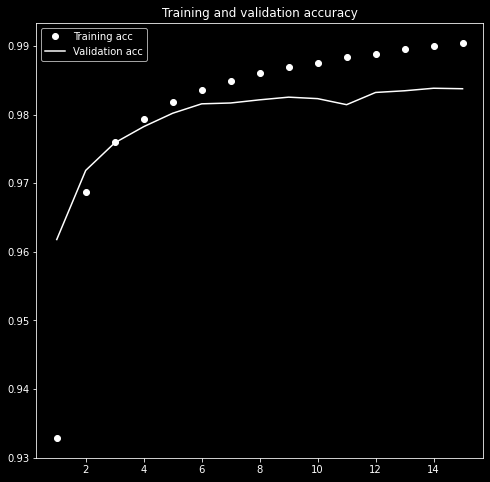

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.figure(figsize = (8,8))
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'wo', label='Training acc')
plt.plot(epochs, val_acc, 'w', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

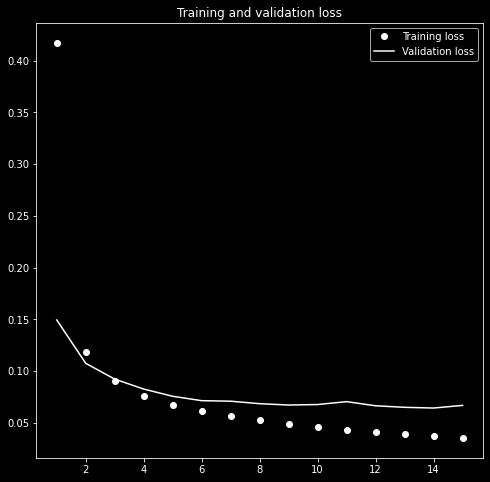

In [ ]:
plt.figure(figsize = (8,8))
plt.plot(epochs, loss, 'wo', label='Training loss')
plt.plot(epochs, val_loss, 'w', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

<a name="5"></a>
# Part 5:  Test the model


In [ ]:
# Convert from one-hot encoding (3D array) to 2D array 
test_padded_tags_pred = model.predict(test_padded_sequences)
test_padded_tags_pred = np.argmax(test_padded_tags_pred, axis=-1)
test_padded_tags_true = np.argmax(test_padded_tags, axis=-1)

In [ ]:
# Convert the index to tag
test_tags_pred =[0]*len(test_padded_tags_pred)
for idx, row in enumerate(test_padded_tags_pred):
    add = []
    for i in row:
        add.append(reverse_tag_map[i]) if i != 0 else add.append("PAD")
    test_tags_pred[idx] = add

test_tags_true =[0]*len(test_padded_tags_true)
for idx, row in enumerate(test_padded_tags_true):
    add = []
    for i in row:
        add.append(reverse_tag_map[i]) if i != 0 else add.append("PAD")
    test_tags_true[idx] = add

In [ ]:
print("Micro F1-score is : {:.1%}".format(f1_score(test_tags_true, test_tags_pred)))
print("Micro Precision-score is : {:.1%}".format(precision_score(test_tags_true, test_tags_pred)))
print("Micro Recall-score is : {:.1%}".format(recall_score(test_tags_true, test_tags_pred)))


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: PAD seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))


Micro F1-score is : 82.8%
Micro Precision-score is : 82.0%
Micro Recall-score is : 83.7%


In [ ]:
!pip install sklearn_crfsuite
from sklearn_crfsuite.metrics import flat_classification_report

report = flat_classification_report(y_pred=test_tags_pred, y_true=test_tags_true)
print(report)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                   precision    recall  f1-score   support

          B-ACTOR       0.89      0.92      0.91       812
      B-CHARACTER       0.70      0.49      0.58        90
       B-DIRECTOR       0.90      0.83      0.87       456
          B-GENRE       0.91      0.94      0.92      1117
           B-PLOT       0.74      0.58      0.65       491
         B-RATING       0.97      0.97      0.97       500
B-RATINGS_AVERAGE       0.91      0.88      0.90       451
         B-REVIEW       0.67      0.04      0.07        56
           B-SONG       0.85      0.52      0.64        54
          B-TITLE       0.79      0.75      0.77       562
        B-TRAILER       0.84      0.90      0.87        30
           B-YEAR       0.95      0.94      0.94       720
          I-ACTOR       0.91      0.89      0.90       862
      I-CHARACTER       0.57      0.39      0.46        75
       I-DIRECTOR       0.89      0.85      0.87       496
          I-GENRE       0.86      0.72      0.78       

In [ ]:
# At every execution model picks some random test sample from test set.
i = np.random.randint(0,test_padded_sequences.shape[0]) # choose a random number between 0 and len(X_te)b
p = model.predict(np.array([test_padded_sequences[i]]))
p = np.argmax(p, axis=-1)
true = np.argmax(test_padded_tags[i], -1)

print("Sample number {} of {} (Test Set)".format(i, test_padded_sequences.shape[0]))
# Visualization
print("{:20}||{:20}||{}".format("Word", "True", "Pred"))
print(60 * "=")
for word, tag, pred in zip(test_padded_sequences[i], true, p[0]):
    if word != 0:
        print("{:20}: {:20} {}".format(reverse_vocab[word], reverse_tag_map[tag], reverse_tag_map[pred]))



Sample number 1175 of 2444 (Test Set)
Word                ||True                ||Pred
did                 : O                    O
steven              : B-DIRECTOR           B-DIRECTOR
spielberg           : I-DIRECTOR           I-DIRECTOR
direct              : O                    O
any                 : O                    O
horror              : B-GENRE              B-GENRE
movie               : O                    O
in                  : O                    O
the                 : O                    O
1980                : B-YEAR               B-YEAR
s                   : I-YEAR               I-YEAR


<a name="6"></a>
# Part 6:  Test with your own sentence

In [ ]:
# if this cell fails => run the 2nd time, it will work

original_to_test = ["is michael scofield the protagonist in prison break", 
                    "what is the highest rated romantic movie in all time"]

to_test = apply_preproc(original_to_test)

vocab_tokenizer.fit_on_texts(to_test)
to_test = vocab_tokenizer.texts_to_sequences(to_test)

to_test = pad_sequences(to_test,
                        maxlen=max_length, 
                        truncating=trunc_type, 
                        padding=pad_type)

to_test_tag_pred = model.predict(to_test)
to_test_tag_pred = np.argmax(to_test_tag_pred, axis=-1)

for i, row in enumerate(to_test_tag_pred):
    print("\n{:20}||{}".format("Word", "Pred"))
    print(40 * "=")
    for j, pred in enumerate(row):
        words = original_to_test[i].split(' ')
        length = len(words)
        if pred != 0 and j < length:
            print("{:20}: {}".format(words[j], reverse_tag_map[pred]))
            

InvalidArgumentError: ignored

<a name="7"></a>
# Part 7: Analyse the incorrect predictions

In [ ]:
def get_incorrect(y_pred, y_true, X_test):
    y_pred.flatten()
    y_true.flatten()
    X_test.flatten()
    where_incorrect = y_true != y_pred
    incorrect_idxes = np.where(where_incorrect==1)[0]
    incorrect_tokens = X_test[incorrect_idxes]
    incorrect_tokens = dict(Counter(incorrect_tokens.flatten()))
    incorrect_tags = y_true[incorrect_idxes]
    incorrect_tags = dict(Counter(incorrect_tags.flatten()))
    return incorrect_tokens, incorrect_tags


incorrect_tokens, incorrect_tags = get_incorrect(test_padded_tags_pred, 
                                                 test_padded_tags_true, 
                                                 test_padded_sequences) 

incorrect_tokens = sorted(incorrect_tokens.items(), key=lambda x:x[1], reverse=True)
incorrect_tags = sorted(incorrect_tags.items(), key=lambda x:x[1], reverse=True)

print("{:^20}||{:^15}".format("Incorrect word", "Frequency"))
print(37 * "=")
for idx, count in incorrect_tokens[:20]:
    if idx != 0:
        print("{:20}: {:15}".format(reverse_vocab[idx], count))

print("\n{:^20}||{:^15}".format("Incorrect tag", "Frequency"))
print(37 * "=")
for idx, count in incorrect_tags[:20]:
    if idx != 0:
        print("{:20}: {:15}".format(reverse_tag_map[idx], count))


## Conclusion after analysis 

1. A lot of incorrect words are stopwords, due to their occurence in the movie titles/plots sometimes. This is the problem of token label inconsistency.
2. The values of macro-average are much lower than micro-average of Precision, Recall and F1-score, as a result of imbalanced classes.


## Potential improvements

1. To tackle imbalanced classes problem, use over-sample to gain more examples of tags from the minority groups.
2. To tackle label inconsistency, there're 3 solutions:

  *   Use larger context. For example, use longer sentences, or combine 2 or more sentences that have similar/corelated meaning.
  *   Use CRF decoder layer.
  *   Use Character/Subword-level encoders like ELMO, Flair, CNN and BERT. 



<a name="8"></a>
# Export result to .tsv file

In [ ]:
# write result to a new txt file
with open('/tmp/pred.tsv', 'wt') as out_file:
    tsv_writer = csv.writer(out_file, delimiter='\t')
    test_size = len(test_padded_sequences)
    for i in range(test_size):
        for pred, word in zip(test_padded_tags_pred[i], test_padded_sequences[i]):
            if pred != 0 and word != 0:
                tsv_writer.writerow([reverse_tag_map[pred], reverse_vocab[word]])
        tsv_writer.writerow([])